In [ ]:
!pip -q install tensorflow==2.15.0 scikit-learn==1.4.2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import itertools
import json, random

In [ ]:
# For reproducibility (as much as possible)
import tensorflow as tf
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#extract the plant village dataset zip file
from zipfile import ZipFile

with ZipFile('/content/plantvillage-dataset.zip','r') as zip:
  zip.extractall()

(256, 256, 3)


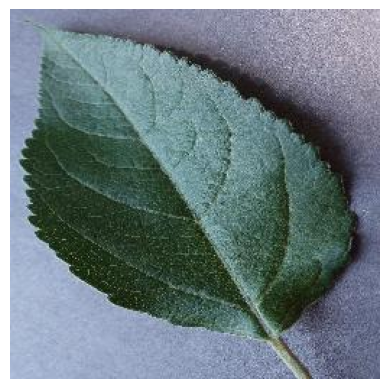

In [ ]:
#print some image photo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_dir = '/content/plantvillage dataset/color/Apple___healthy/011d02f3-5c3c-4484-a384-b1a0a0dbdec1___RS_HL 7544.JPG'
img = mpimg.imread(image_dir)

#shape of image
print(img.shape)

#ploting the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
TRAIN_DIR = ""
VAL_DIR   = ""

In [ ]:
USE_SEPARATE_VAL_DIRS = False  # set to False if you want Keras split from a single folder
DATA_DIR = "/content/plantvillage dataset/color"  # only used when USE_SEPARATE_VAL_DIRS=False

In [ ]:
# =========================
# 2) Hyperparameters
# =========================
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS_FROZEN = 8     # initial training with base frozen
EPOCHS_FINE   = 20    # fine-tuning epochs (with EarlyStopping)
LR_FROZEN = 1e-3
LR_FINE   = 1e-5

In [ ]:
# =========================
# 3) Data Generators
# =========================
if USE_SEPARATE_VAL_DIRS:
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        seed=SEED
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,   # important for correct y_true alignment
        seed=SEED
    )

else:
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="training",
        shuffle=True,
        seed=SEED
    )

    val_generator = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="validation",
        shuffle=False,
        seed=SEED
    )

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [ ]:
NUM_CLASSES = train_generator.num_classes
CLASS_INDICES = train_generator.class_indices
IDX2CLASS = {v:k for k,v in CLASS_INDICES.items()}
print("Classes:", json.dumps(CLASS_INDICES, indent=2))

Classes: {
  "Apple___Apple_scab": 0,
  "Apple___Black_rot": 1,
  "Apple___Cedar_apple_rust": 2,
  "Apple___healthy": 3,
  "Blueberry___healthy": 4,
  "Cherry_(including_sour)___Powdery_mildew": 5,
  "Cherry_(including_sour)___healthy": 6,
  "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": 7,
  "Corn_(maize)___Common_rust_": 8,
  "Corn_(maize)___Northern_Leaf_Blight": 9,
  "Corn_(maize)___healthy": 10,
  "Grape___Black_rot": 11,
  "Grape___Esca_(Black_Measles)": 12,
  "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)": 13,
  "Grape___healthy": 14,
  "Orange___Haunglongbing_(Citrus_greening)": 15,
  "Peach___Bacterial_spot": 16,
  "Peach___healthy": 17,
  "Pepper,_bell___Bacterial_spot": 18,
  "Pepper,_bell___healthy": 19,
  "Potato___Early_blight": 20,
  "Potato___Late_blight": 21,
  "Potato___healthy": 22,
  "Raspberry___healthy": 23,
  "Soybean___healthy": 24,
  "Squash___Powdery_mildew": 25,
  "Strawberry___Leaf_scorch": 26,
  "Strawberry___healthy": 27,
  "Tomato___Bacterial_spot": 

In [ ]:
# =========================
# 4) Compute Class Weights (handle imbalance)
# =========================
# Keras DirectoryIterator exposes .classes (label index per sample)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
CLASS_WEIGHTS = {i:w for i,w in enumerate(class_weights_array)}
print("Class weights (sample):", dict(list(CLASS_WEIGHTS.items())[:10]))


Class weights (sample): {0: np.float64(2.2690058479532165), 1: np.float64(2.300963676797628), 2: np.float64(5.198086124401914), 3: np.float64(0.8689809630459127), 4: np.float64(0.9513967948156581), 5: np.float64(1.3581697712214027), 6: np.float64(1.6718990458602647), 7: np.float64(2.7824305288769366), 8: np.float64(1.1987200706167935), 9: np.float64(1.4512423189954582)}


In [ ]:
# =========================
# 5) Build Model: VGG16 base + lightweight classifier
#    (GAP head reduces params vs Flatten; better regularization)
# =========================
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze for initial training

x = base_model.output
x = GlobalAveragePooling2D()(x)           # or use Flatten() if you prefer
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(LR_FROZEN),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,996,838 (57.21 MB)

 Trainable params: 282,150 (1.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# =========================
# 6) Callbacks (Checkpoints/EarlyStopping/LR scheduler)
# =========================
ckpt_frozen = ModelCheckpoint(
    "vgg16_frozen_best.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_frozen = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# =========================
# 7) Train (Frozen base)
# =========================
history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FROZEN,
    class_weight=CLASS_WEIGHTS,
    callbacks=[ckpt_frozen, early_frozen, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5613 - loss: 1.8954
Epoch 1: val_accuracy improved from -inf to 0.87584, saving model to vgg16_frozen_best.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 738s 532ms/step - accuracy: 0.5614 - loss: 1.8948 - val_accuracy: 0.8758 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 2/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8194 - loss: 0.5746
Epoch 2: val_accuracy improved from 0.87584 to 0.90451, saving model to vgg16_frozen_best.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 708s 522ms/step - accuracy: 0.8194 - loss: 0.5745 - val_accuracy: 0.9045 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 3/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8475 - loss: 0.4802
Epoch 3: val_accuracy improved from 0.90451 to 0.90819, saving model to vgg16_frozen_best.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 709s 522ms/step - accuracy: 0.8475 - loss: 0.4802 - val_accuracy: 0.9082 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 4/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8577 - loss: 0.4411
Epoch 4: val_accuracy improved from 0.90819 to 0.92294, saving model to vgg16_frozen_best.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 707s 521ms/step - accuracy: 0.8577 - loss: 0.4411 - val_accuracy: 0.9229 - val_loss: 0.2382 - learning_rate: 0.0010
Epoch 5/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8667 - loss: 0.4292
Epoch 5: val_accuracy did not improve from 0.92294
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 779s 573ms/step - accuracy: 0.8667 - loss: 0.4292 - val_accuracy: 0.9192 - val_loss: 0.2426 - learning_rate: 0.0010
Epoch 6/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8687 - loss: 0.4202
Epoch 6: val_accuracy improved from 0.92294 to 0.92580, saving model to vgg16_frozen_best.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 725s 534ms/step - accuracy: 0.8687 - loss: 0.4202 - val_accuracy: 0.9258 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 7/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8705 - loss: 0.4161
Epoch 7: val_accuracy did not improve from 0.92580
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 705s 519ms/step - accuracy: 0.8705 - loss: 0.4160 - val_accuracy: 0.9129 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 8/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8721 - loss: 0.4039
Epoch 8: val_accuracy improved from 0.92580 to 0.92681, saving model to vgg16_frozen_best.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 704s 519ms/step - accuracy: 0.8721 - loss: 0.4039 - val_accuracy: 0.9268 - val_loss: 0.2221 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 6.


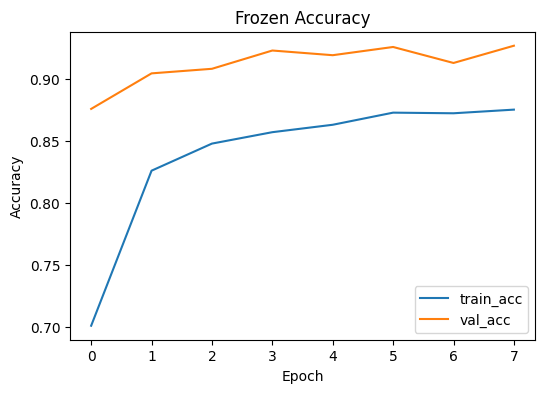

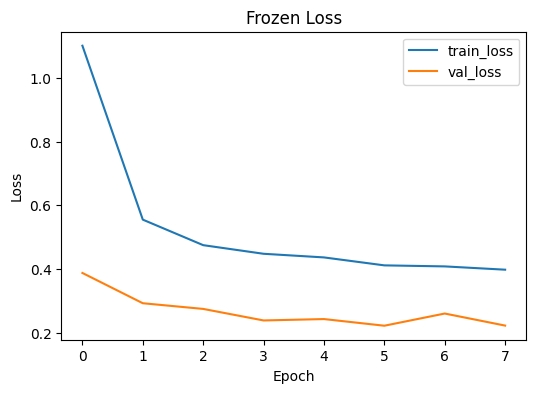

In [ ]:
# Optional: plot training curves
def plot_history(h, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title_prefix} Accuracy'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title_prefix} Loss'); plt.legend(); plt.show()

plot_history(history_frozen, "Frozen")


In [ ]:
# =========================
# 8) Fine-tune: unfreeze top VGG16 block(s)
#    Start with block5 to avoid catastrophic forgetting
# =========================
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block5"):   # unfreeze only block5_*
        layer.trainable = True

model.compile(optimizer=Adam(LR_FINE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

ckpt_finetune = ModelCheckpoint(
    "vgg16_finetuned_best.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_finetune = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[ckpt_finetune, early_finetune, reduce_lr]
)

In [ ]:
plot_history(history_fine, "Fine-tuned")


In [ ]:
# =========================
# 9) Evaluate on Validation Set
# =========================
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_acc*100:.2f}%  |  Validation Loss: {val_loss:.4f}")

# Optionally load the absolute best (by val_accuracy) before reporting:
BEST_MODEL_PATH = "vgg16_finetuned_best.h5" if os.path.exists("vgg16_finetuned_best.h5") else "vgg16_frozen_best.h5"
best_model = load_model(BEST_MODEL_PATH)
best_val_loss, best_val_acc = best_model.evaluate(val_generator, verbose=0)
print(f"[Loaded Best] Val Acc: {best_val_acc*100:.2f}%  |  Val Loss: {best_val_loss:.4f}  |  File: {BEST_MODEL_PATH}")


  9/340 ━━━━━━━━━━━━━━━━━━━━ 2:37 477ms/step - accuracy: 0.8899 - loss: 0.3531

KeyboardInterrupt: 

In [ ]:
# =========================
# 10) Detailed Evaluation: Predictions, Report, Confusion Matrix
# =========================
# Ensure val_generator was created with shuffle=False
y_true = val_generator.classes
y_prob = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

target_names = [IDX2CLASS[i] for i in range(NUM_CLASSES)]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# Confusion matrix plot (top-38 can be dense; still useful)
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i < len(classes) and j < len(classes):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     fontsize=7,
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, target_names, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, target_names, normalize=True,  title="Confusion Matrix (Normalized)")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================
# 11) Save final model + class index for later inference (Streamlit)
# =========================
best_model.save("/content/drive/MyDrive/Machine-Learning-Projects/plant_vgg16_best.h5")
with open("class_indices.json", "w") as f:
    json.dump(CLASS_INDICES, f, indent=2)
print("Saved: plant_vgg16_best.h5 and class_indices.json")

Saved: plant_vgg16_best.h5 and class_indices.json


In [ ]:

# =========================
# 12) Single-image Inference Helper
# =========================
from tensorflow.keras.preprocessing import image as kimage

def predict_image(img_path, model, idx2class=IDX2CLASS, img_size=IMG_SIZE, top_k=5):
    img = kimage.load_img(img_path, target_size=(img_size, img_size))
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    probs = model.predict(arr)[0]
    top_idx = probs.argsort()[::-1][:top_k]
    return [(idx2class[i], float(probs[i])) for i in top_idx]


In [ ]:
print(predict_image("/content/plantvillage dataset/color/Cherry_(including_sour)___Powdery_mildew/00f8611c-0f2c-4f24-8241-d1748c8bb48f___FREC_Pwd.M 0479.JPG", best_model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
[('Cherry_(including_sour)___Powdery_mildew', 0.9999983310699463), ('Orange___Haunglongbing_(Citrus_greening)', 1.4791930880164728e-06), ('Apple___Cedar_apple_rust', 1.525164918803057e-07), ('Corn_(maize)___Northern_Leaf_Blight', 5.7804651731885315e-08), ('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 4.036646572558311e-08)]
